# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science

## Final Project: Predicting the 2018 World Cup

**Harvard University**<br/>
**Summer 2018**<br/>
**Team**: Bruno Janota, Hans Chacko

<hr style="height:2pt">

### Project Overview

The goal of this project will be to leverage various sources of team/player data, historical international match results, historical FIFA rankings, and betting odds to construct a 2018 FIFA World Cup prediction model. The model will predict a win, loss, or draw match outcome for historical international matches from 1993 to 2018 divided into a training and testing set and evaluate those predictions against the baseline of predictions from simply incorporating FIFA ranking as a naïve measure of team strength (i.e. the team with a higher ranking should win). In addition to predicting historical international matches, the classification model will also be used to predict the outcome of the 2018 FIFA World Cup. 

The project will be split into three parts:
1.	Combine the international match outcome and FIFA rankings data sets for matches between 1993 and 2018. Perform some basic feature engineering to add additional features. Lastly, perform a 70/30% train/test set split and evaluate the performance of a Random Forest model on the overall classification accuracy on the test set. This will be the baseline model.
2.	Replace the FIFA rankings in Part 1 with an Elo based scoring model and assess improvement, if any, on the overall classification accuracy on the same test set used in part 1.
3.	The optimal combination of features from parts 1 and 2 (may include FIFA rank, Elo score, or both) will be used to train a variety of classification models (Random Forest, xgboost, LDA, QDA, KNN, etc.). The probabilistic results for each match (win, tie, loss) will be blended with the results of a Poisson Distribution model that uses the complete player ranking data scraped from sofifa.com for the FIFA 2018 video game to predict the group stages of the 2018 FIFA World Cup. The knockout stages of the world cup will be simulated 1000 times to determine the probability of each team winning the tournament. Matches that result in a tie during the knockout stages will take into account the average penalty rating of the top 5 penalty shooters for each time from the sofifa.com data set to break the tie. The final result will be the probability of each of the 32 teams that qualified for the 2018 World Cup to win the tournament. 


<hr style="height:2pt">

In [3]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline

C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Part 1: Baseline Model with FIFA Rankings
### Load, Clean, and Merge Data

In [4]:
# load historical FIFA rankings (1993-present) dataset into pandas dataframe
fifaRank_df = pd.read_csv('FifaRanking1993to2018_Tadhg Fitzgerald.csv')
fifaRank_df = fifaRank_df.loc[:,['rank', 'country_full', 'country_abrv', 'rank_date', 'total_points', 'previous_points',
                                 'cur_year_avg_weighted', 'two_year_ago_weighted', 'three_year_ago_weighted']]
fifaRank_df = fifaRank_df.replace({"IR Iran": "Iran"})
fifaRank_df['rank_date'] = pd.to_datetime(fifaRank_df['rank_date'])

fifaRank_df.head()

,rank,country_full,country_abrv,rank_date,total_points,previous_points,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted
0,1,Germany,GER,1993-08-08,0.0,57,0.0,0.0,0.0
1,2,Italy,ITA,1993-08-08,0.0,57,0.0,0.0,0.0
2,3,Switzerland,SUI,1993-08-08,0.0,50,0.0,0.0,0.0
3,4,Sweden,SWE,1993-08-08,0.0,55,0.0,0.0,0.0
4,5,Argentina,ARG,1993-08-08,0.0,51,0.0,0.0,0.0


In [5]:
# load international match results (1872-2018) dataset into pandas dataframe
results_df = pd.read_csv('InternationalResultsFrom1993to2018.csv')
results_df =  results_df.replace({'Germany DR': 'Germany', 'China': 'China PR'})
results_df['date'] = pd.to_datetime(results_df['date'])

results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False


In [6]:
# load country region and income group data into pandas dataframe
country_df = pd.read_csv('WorldCountryData.csv')

# Convert categorical variables using one-hot encoding
country_df = pd.get_dummies(country_df, columns=['Region','IncomeGroup'], drop_first=True)
country_df.head()

,ShortName,Region_Europe & Central Asia,Region_Latin America & Caribbean,Region_Middle East & North Africa,Region_North America,Region_South Asia,Region_Sub-Saharan Africa,IncomeGroup_High income: nonOECD,IncomeGroup_Low income,IncomeGroup_Lower middle income,IncomeGroup_Upper middle income
0,Afghanistan,0,0,0,0,1,0,0,1,0,0
1,Albania,1,0,0,0,0,0,0,0,0,1
2,Algeria,0,0,1,0,0,0,0,0,0,1
3,American Samoa,0,0,0,0,0,0,0,0,0,1
4,Andorra,1,0,0,0,0,0,1,0,0,0


In [7]:
# get ranks for every day 
fifaRank_df = fifaRank_df.set_index(['rank_date'])\
                        .groupby(['country_full'], group_keys=False)\
                        .resample('D').first()\
                        .fillna(method='ffill')\
                        .reset_index()

# join the ranks
results_df = results_df.merge(fifaRank_df, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
results_df = results_df.merge(fifaRank_df, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

# join region and income group data
results_df = results_df.merge(country_df, 
                        left_on=['home_team'], 
                        right_on=['ShortName'])
results_df = results_df.merge(country_df, 
                        left_on=['away_team'], 
                        right_on=['ShortName'], 
                        suffixes=('_home', '_away'))


results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,Region_Europe & Central Asia_away,Region_Latin America & Caribbean_away,Region_Middle East & North Africa_away,Region_North America_away,Region_South Asia_away,Region_Sub-Saharan Africa_away,IncomeGroup_High income: nonOECD_away,IncomeGroup_Low income_away,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0,1,0,0,0,0,1,0,0,0
1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,La Paz,Bolivia,False,1997-06-18,...,0,1,0,0,0,0,1,0,0,0
2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,La Paz,Bolivia,False,1997-07-20,...,0,1,0,0,0,0,1,0,0,0
3,2000-11-15,Bolivia,Uruguay,0,0,FIFA World Cup qualification,La Paz,Bolivia,False,2000-11-15,...,0,1,0,0,0,0,1,0,0,0
4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,Medellín,Colombia,True,2001-07-13,...,0,1,0,0,0,0,1,0,0,0


In [8]:
results_df.shape

(14997, 49)

In [9]:
# generate additional features
results_df['rank_difference'] = results_df['rank_home'] - results_df['rank_away']
results_df['average_rank'] = (results_df['rank_home'] + results_df['rank_away'])/2
results_df['score_difference'] = results_df['home_score'] - results_df['away_score']
results_df['is_stake'] = results_df['tournament'] != 'Friendly'
results_df['total_goals'] = results_df['home_score'] + results_df['away_score'] 
results_df['year'] = results_df['date'].dt.year

winner = []
result = []
for i in range (len(results_df['home_team'])):
    if results_df['home_score'][i] > results_df['away_score'][i]:
        winner.append(results_df['home_team'][i])
        result.append(1.0)
    elif results_df['home_score'][i] < results_df ['away_score'][i]:
        winner.append(results_df['away_team'][i])
        result.append(0.0)
    else:
        winner.append('Draw')
        result.append(0.5)

results_df['winning_team'] = winner
results_df['result'] = result

results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away,rank_difference,average_rank,score_difference,is_stake,total_goals,year,winning_team,result
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0,0,37.0,40.5,2,True,4,1993,Bolivia,1.0
1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,La Paz,Bolivia,False,1997-06-18,...,0,0,-17.0,42.5,1,True,1,1997,Bolivia,1.0
2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,La Paz,Bolivia,False,1997-07-20,...,0,0,-26.0,31.0,1,True,1,1997,Bolivia,1.0
3,2000-11-15,Bolivia,Uruguay,0,0,FIFA World Cup qualification,La Paz,Bolivia,False,2000-11-15,...,0,0,30.0,51.0,0,True,0,2000,Draw,0.5
4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,Medellín,Colombia,True,2001-07-13,...,0,0,26.0,53.0,-1,True,1,2001,Uruguay,0.0


In [10]:
print('Total International Matches played between 1993-2018: {}'.format(results_df['result'].count()))

Total International Matches played between 1993-2018: 14997


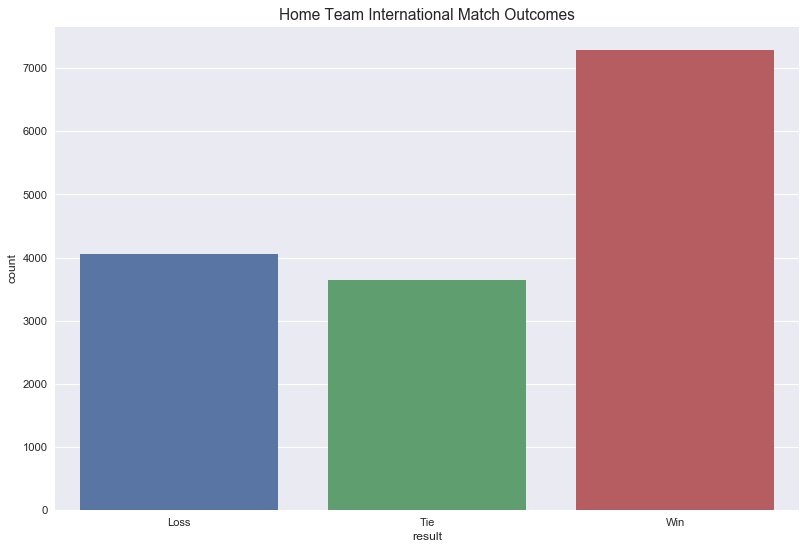

In [11]:
plt.figure(figsize=(12, 8), dpi= 80)
sns.set(style='darkgrid')
sns.countplot(x='result', data = results_df)
plt.xticks(range(3), ['Loss','Tie','Win'])
plt.title('Home Team International Match Outcomes', fontsize=14)
plt.show()

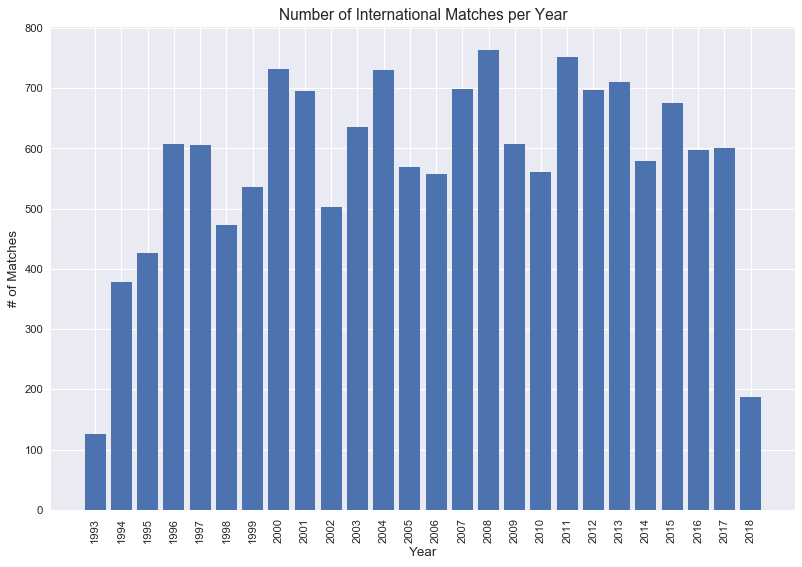

In [12]:
games_per_year = results_df.groupby(['year'])['year'].count()
years = ['1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018']
plt.figure(figsize=(12, 8), dpi= 80)
plt.bar(range(len(games_per_year)), games_per_year)
plt.xticks(range(len(games_per_year)), years, rotation = 90)
plt.title('Number of International Matches per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('# of Matches', fontsize=12)
plt.show()

In [13]:
# Narrowing to teams that qualified for 2018 world cup
worldcup_teams = ['Australia', ' Iran', 'Japan', 'Korea Republic', 
            'Saudi Arabia', 'Egypt', 'Morocco', 'Nigeria', 
            'Senegal', 'Tunisia', 'Costa Rica', 'Mexico', 
            'Panama', 'Argentina', 'Brazil', 'Colombia', 
            'Peru', 'Uruguay', 'Belgium', 'Croatia', 
            'Denmark', 'England', 'France', 'Germany', 
            'Iceland', 'Poland', 'Portugal', 'Russia', 
            'Serbia', 'Spain', 'Sweden', 'Switzerland']
df_teams_home = results_df[results_df['home_team'].isin(worldcup_teams)]
df_teams_away = results_df[results_df['away_team'].isin(worldcup_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams = df_teams.reset_index()
df_teams = df_teams.drop_duplicates()

df_teams.head()

,index,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,...,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away,rank_difference,average_rank,score_difference,is_stake,total_goals,year,winning_team,result
0,10,1993-09-19,Brazil,Uruguay,2,0,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,...,0,0,-14.0,15.0,2,True,2,1993,Brazil,1.0
1,11,1995-10-11,Brazil,Uruguay,2,0,Friendly,Salvador,Brazil,False,...,0,0,-35.0,18.5,2,False,2,1995,Brazil,1.0
2,12,1999-07-18,Brazil,Uruguay,3,0,Copa América,Asunción,Paraguay,True,...,0,0,-73.0,37.5,3,True,3,1999,Brazil,1.0
3,13,2000-06-28,Brazil,Uruguay,1,1,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,...,0,0,-42.0,22.0,0,True,2,2000,Draw,0.5
4,14,2003-11-19,Brazil,Uruguay,3,3,FIFA World Cup qualification,Curitiba,Brazil,False,...,0,0,-19.0,10.5,0,True,6,2003,Draw,0.5


In [14]:
results_df.describe()

,home_score,away_score,rank_home,total_points_home,previous_points_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,rank_away,total_points_away,...,IncomeGroup_High income: nonOECD_away,IncomeGroup_Low income_away,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away,rank_difference,average_rank,score_difference,total_goals,year,result
count,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,...,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.00000,14997.000000,14997.000000,14997.000000,14997.000000
mean,1.587584,1.048543,75.442622,153.037453,424.446556,77.112791,22.194996,15.363607,77.693539,147.574908,...,0.163099,0.142095,0.225712,0.276655,-2.250917,76.56808,0.539041,2.636127,2006.068814,0.608122
std,1.567929,1.220071,49.928677,300.513033,318.589583,157.394007,46.525233,32.006384,50.717812,291.576207,...,0.369469,0.349159,0.418064,0.447359,52.260068,43.00937,2.127197,1.835480,6.842428,0.421358
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-202.000000,1.50000,-17.000000,0.000000,1993.000000,0.000000
25%,0.000000,0.000000,34.000000,0.000000,150.000000,0.000000,0.000000,0.000000,36.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-35.000000,42.00000,-1.000000,1.000000,2000.000000,0.000000
50%,1.000000,1.000000,70.000000,0.000000,408.000000,0.000000,0.000000,0.000000,71.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-3.000000,72.50000,0.000000,2.000000,2006.000000,0.500000
75%,2.000000,2.000000,110.000000,193.950000,610.000000,83.550000,19.050000,14.170000,113.000000,178.090000,...,0.000000,0.000000,0.000000,1.000000,30.000000,105.50000,2.000000,4.000000,2012.000000,1.000000
max,31.000000,17.000000,209.000000,1770.060000,1887.000000,1126.040000,347.600000,231.730000,209.000000,1770.060000,...,1.000000,1.000000,1.000000,1.000000,202.000000,204.00000,31.000000,31.000000,2018.000000,1.000000


In [15]:
print('Total International Matches played by 2018 World Cup teams between 1993-2018: {}'.format(df_teams['result'].count()))

Total International Matches played by 2018 World Cup teams between 1993-2018: 6077


# Naive Model based on FIFA Ranking Only

In [16]:
df_teams['fifa_correct_withDraws'] = ((df_teams.home_score >= df_teams.away_score) & (df_teams.rank_home > df_teams.rank_away)) | ((df_teams.away_score >= df_teams.home_score) & (df_teams.rank_away > df_teams.rank_home))
df_teams['fifa_correct'] = ((df_teams.home_score > df_teams.away_score) & (df_teams.rank_home > df_teams.rank_away)) | ((df_teams.away_score > df_teams.home_score) & (df_teams.rank_away > df_teams.rank_home))

print('Accuracy of FIFA Ranking at Predicting Winner: {}%'
      .format(round(df_teams.fifa_correct.sum()/df_teams.fifa_correct.count()*100, 2)))

Accuracy of FIFA Ranking at Predicting Winner: 19.75%


In [17]:
no_Draws_df = df_teams.loc[df_teams['result'] != 0.5].copy()
no_Draws_df['fifa_correct_withDraws'] = ((no_Draws_df.home_score >= no_Draws_df.away_score) & (no_Draws_df.rank_home > no_Draws_df.rank_away)) | ((no_Draws_df.away_score >= no_Draws_df.home_score) & (no_Draws_df.rank_away > no_Draws_df.rank_home))
no_Draws_df['fifa_correct'] = ((no_Draws_df.home_score > no_Draws_df.away_score) & (no_Draws_df.rank_home > no_Draws_df.rank_away)) | ((no_Draws_df.away_score > no_Draws_df.home_score) & (no_Draws_df.rank_away > no_Draws_df.rank_home))
no_Draws_df.head()

,index,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,...,rank_difference,average_rank,score_difference,is_stake,total_goals,year,winning_team,result,fifa_correct_withDraws,fifa_correct
0,10,1993-09-19,Brazil,Uruguay,2,0,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,...,-14.0,15.0,2,True,2,1993,Brazil,1.0,False,False
1,11,1995-10-11,Brazil,Uruguay,2,0,Friendly,Salvador,Brazil,False,...,-35.0,18.5,2,False,2,1995,Brazil,1.0,False,False
2,12,1999-07-18,Brazil,Uruguay,3,0,Copa América,Asunción,Paraguay,True,...,-73.0,37.5,3,True,3,1999,Brazil,1.0,False,False
5,15,2007-11-21,Brazil,Uruguay,2,1,FIFA World Cup qualification,São Paulo,Brazil,False,...,-15.0,9.5,1,True,3,2007,Brazil,1.0,False,False
6,16,2013-06-26,Brazil,Uruguay,2,1,Confederations Cup,Belo Horizonte,Brazil,False,...,3.0,20.5,1,True,3,2013,Brazil,1.0,True,True


In [18]:
print('Accuracy of FIFA Ranking at Predicting Winner (ignoring draws): {}%'
      .format(round(no_Draws_df.fifa_correct.sum()/no_Draws_df.fifa_correct.count()*100, 2)))

Accuracy of FIFA Ranking at Predicting Winner (ignoring draws): 26.12%


# Visualize Subset of the Data for Portugal Matches Only

In [19]:
# Let's work with a subset of the data that includes games played by Portugal
portugal = results_df[(results_df['home_team'] == 'Portugal') | (results_df['away_team'] == 'Portugal')]
portugal.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away,rank_difference,average_rank,score_difference,is_stake,total_goals,year,winning_team,result
263,2013-02-06,Portugal,Ecuador,2,3,Friendly,Guimarães,Portugal,False,2013-02-06,...,0,1,-5.0,9.5,-1,False,5,2013,Ecuador,0.0
633,2017-11-10,Portugal,Saudi Arabia,3,0,Friendly,Viseu,Portugal,False,2017-11-10,...,0,0,-60.0,33.0,3,False,3,2017,Portugal,1.0
800,2010-06-01,Portugal,Cameroon,3,1,Friendly,Covilhã,Portugal,False,2010-06-01,...,1,0,-16.0,11.0,2,False,4,2010,Portugal,1.0
801,2014-03-05,Portugal,Cameroon,5,1,Friendly,Leiria,Portugal,False,2014-03-05,...,1,0,-42.0,25.0,4,False,6,2014,Portugal,1.0
1081,1993-10-13,Portugal,Switzerland,1,0,FIFA World Cup qualification,Porto,Portugal,False,1993-10-13,...,0,0,11.0,15.5,1,True,1,1993,Portugal,1.0


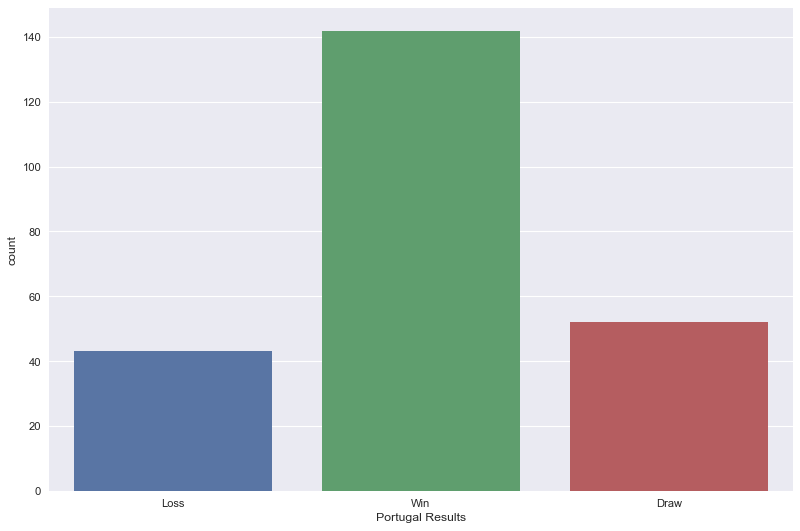

In [20]:
# Visualize Portugal game outcomes
wins = []
for row in portugal['winning_team']:
    if row != 'Portugal' and row != 'Draw':
        wins.append('Loss')
    elif row == 'Draw':
        wins.append('Draw')
    else:
        wins.append('Win')
        
winsdf= pd.DataFrame(wins, columns=['Portugal Results'])

plt.figure(figsize=(12, 8), dpi= 80)
sns.set(style='darkgrid')
sns.countplot(x='Portugal Results', data=winsdf)

# Evaluate Baseline Decision Tree Model

In [21]:
# remove features without predictive value or not known prior to game start
train_df = df_teams[['rank_home','rank_away','neutral','previous_points_home','cur_year_avg_weighted_home',
                     'two_year_ago_weighted_home','three_year_ago_weighted_home','previous_points_away',
                     'cur_year_avg_weighted_away','two_year_ago_weighted_away','three_year_ago_weighted_away',
                     'rank_difference','average_rank','is_stake','Region_Europe & Central Asia_home',
                     'Region_Latin America & Caribbean_home','Region_Middle East & North Africa_home',
                     'Region_North America_home','Region_South Asia_home','Region_Sub-Saharan Africa_home',
                     'IncomeGroup_High income: nonOECD_home','IncomeGroup_Low income_home',
                     'IncomeGroup_Lower middle income_home','IncomeGroup_Upper middle income_home',
                     'Region_Europe & Central Asia_away','Region_Latin America & Caribbean_away',
                     'Region_Middle East & North Africa_away','Region_North America_away','Region_South Asia_away',
                     'Region_Sub-Saharan Africa_away','IncomeGroup_High income: nonOECD_away','IncomeGroup_Low income_away',
                     'IncomeGroup_Lower middle income_away','IncomeGroup_Upper middle income_away','result']]

In [194]:
# split training set in features/labels
features = train_df.drop(['result'], axis = 1)
labels = np.asarray(train_df['result'], dtype="|S6")

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, 
                                                                            random_state = 42)

# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train_labels))
print('Number of observations in the test data:',len(test_labels))

Number of observations in the training data: 4557
Number of observations in the test data: 1520


The optimal tree depth is: 4


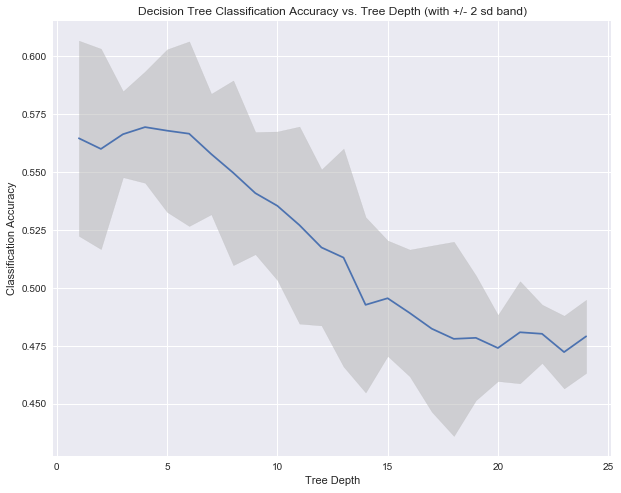

In [195]:
tree_depth = list(range(1,25))

cv_scores_mean = []
cv_scores_std = []
for depth in tree_depth:
    baselineModel = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(baselineModel, train_features, train_labels, cv=5, scoring='accuracy')
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
# determining best tree depth
optimal_depth = tree_depth[cv_scores_mean.index(max(cv_scores_mean))]
print('The optimal tree depth is: {}'.format(optimal_depth))

# plot classification accuracy vs tree depth
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(tree_depth, cv_scores_mean)
plt.fill_between(tree_depth, (np.array(cv_scores_mean) - 2*np.array(cv_scores_std)), 
                 (np.array(cv_scores_mean) + 2*np.array(cv_scores_std)), color = [0.7, 0.7, 0.7], alpha = 0.5)
plt.title('Decision Tree Classification Accuracy vs. Tree Depth (with +/- 2 sd band)')
plt.xlabel('Tree Depth')
plt.ylabel('Classification Accuracy')
plt.show()

In [196]:
baselineModel = DecisionTreeClassifier(max_depth=4).fit(train_features, train_labels)

print('Decision Tree Classifier (FIFA rank only):')
print('Classification Accuracy on training set: {}%'.format(round(baselineModel.score(train_features, train_labels,)*100, 2)))
print('Classification Accuracy on testing set: {}%\n'.format(round(baselineModel.score(test_features, test_labels,)*100, 2)))

Decision Tree Classifier (FIFA rank only):
Classification Accuracy on training set: 58.31%
Classification Accuracy on testing set: 57.11%



In [197]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os
import sys

# Fix pydotplus error that it can't find Graphviz executables from:
# https://stackoverflow.com/questions/42235431/ipython-3-5-graphvizs-executables-not-found-after-installing-graphviz-and-pydot
def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)

dot_data = StringIO()
export_graphviz(baselineModel, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
conda_fix(graph)

# View the decision tree for baseline model
#Image(graph.create_png())

# Part 2: Add Elo Rating to FIFA Rank Model


In [198]:
# prepare dataframes for Elo Rankings
elo_games_df = df_teams[['date','home_team','away_team','home_score','away_score','tournament','result']].reset_index()
elo_games_df['home_elo_before_game'] = 0
elo_games_df['home_elo_after_game'] = 0
elo_games_df['away_elo_before_game'] = 0
elo_games_df['away_elo_after_game'] = 0
elo_games_df.head()

,index,date,home_team,away_team,home_score,away_score,tournament,result,home_elo_before_game,home_elo_after_game,away_elo_before_game,away_elo_after_game
0,0,1993-09-19,Brazil,Uruguay,2,0,FIFA World Cup qualification,1.0,0,0,0,0
1,1,1995-10-11,Brazil,Uruguay,2,0,Friendly,1.0,0,0,0,0
2,2,1999-07-18,Brazil,Uruguay,3,0,Copa América,1.0,0,0,0,0
3,3,2000-06-28,Brazil,Uruguay,1,1,FIFA World Cup qualification,0.5,0,0,0,0
4,4,2003-11-19,Brazil,Uruguay,3,3,FIFA World Cup qualification,0.5,0,0,0,0


In [199]:
elo_games_df['tournament'].unique()

array(['FIFA World Cup qualification', 'Friendly', 'Copa América',
       'Confederations Cup', 'FIFA World Cup', 'Kirin Cup', 'Korea Cup',
       'USA Cup', 'Gold Cup', 'AFC Asian Cup',
       'AFC Asian Cup qualification', 'African Cup of Nations',
       'African Cup of Nations qualification', 'UEFA Euro qualification',
       'UEFA Euro', 'Lunar New Year Cup', 'Copa del Pacífico',
       'King Hassan II Tournament', 'Tournoi de France', 'UNCAF Cup',
       'Gold Cup qualification', 'Malta International Tournament',
       'Nordic Championship', "King's Cup", 'Simba Tournament',
       'African Nations Championship',
       'United Arab Emirates Friendship Tournament', 'EAFF Championship',
       'Oceania Nations Cup', 'OSN Cup',
       'Cyprus International Tournament', 'UAFA Cup', 'Gulf Cup',
       "Prime Minister's Cup", 'Nile Basin Tournament',
       'Amílcar Cabral Cup', 'WAFF Championship', 'Millennium Cup'],
      dtype=object)

In [200]:
teams = pd.unique(elo_games_df[['home_team', 'away_team']].values.ravel('K'))
elo_teams_df = pd.DataFrame({'team': teams, 'elo': 1500})
elo_teams_df.head()

,elo,team
0,1500,Brazil
1,1500,Peru
2,1500,Australia
3,1500,Colombia
4,1500,Argentina


### Compute Elo Ratings

In [201]:
# Set some constants
mean_elo = 1500
elo_width = 400

In [202]:
def update_elo(home_elo, away_elo, match_result, match_type, home_score, away_score):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    if(match_type == 'FIFA World Cup'):
        k_factor = 60.0
    elif(match_type == 'Friendly'):
        k_factor = 20.0
    else:
        k_factor = 40.0    
    
    if(home_score == away_score):
        goal_factor = 1.0
    elif(np.abs(home_score - away_score) == 2):
        goal_factor = 1.5
    else:
        goal_factor = (11 + np.abs(home_score - away_score))/8        
    
    expected_win = expected_result(home_elo, away_elo)
    change_in_elo = k_factor * goal_factor * (match_result - expected_win)
    home_elo += change_in_elo
    away_elo -= change_in_elo
    
    return home_elo, away_elo

def expected_result(elo_a, elo_b):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

#### The loop where it happens
- We go through each row in the DataFrame.
- We look up the current Elo rating of both teams.
- We calculate the expected wins for the team that actually won.
- Write Elo before and after the game in the Data Frame.
- Update the Elo rating for both teams in the "current_elos" list.

In [203]:
current_season = elo_games_df.date[:0].dt.year
for row in elo_games_df.itertuples():
       
    idx = row.Index
    home_team = row.home_team
    away_team = row.away_team
  
    # Get pre-match ratings
    teamA_elo = elo_teams_df.loc[elo_teams_df['team'] == home_team, 'elo'].values[0]
    teamB_elo = elo_teams_df.loc[elo_teams_df['team'] == away_team, 'elo'].values[0]

    # Update on game results
    home_elo_after, away_elo_after = update_elo(teamA_elo, teamB_elo, row.result, row.tournament, 
                                                row.home_score, row.away_score)
        
    # Save updated elos
    elo_games_df.at[idx, 'home_elo_before_game'] = teamA_elo
    elo_games_df.at[idx, 'away_elo_before_game'] = teamB_elo
    elo_games_df.at[idx, 'home_elo_after_game'] = home_elo_after
    elo_games_df.at[idx, 'away_elo_after_game'] = away_elo_after
    
    # update current elos
    elo_teams_df.set_value(elo_teams_df.loc[elo_teams_df.team == home_team].index.values[0], 'elo', home_elo_after)
    elo_teams_df.set_value(elo_teams_df.loc[elo_teams_df.team == away_team].index.values[0], 'elo', away_elo_after)

elo_games_df.head()

,index,date,home_team,away_team,home_score,away_score,tournament,result,home_elo_before_game,home_elo_after_game,away_elo_before_game,away_elo_after_game
0,0,1993-09-19,Brazil,Uruguay,2,0,FIFA World Cup qualification,1.0,1500,1530,1500,1470
1,1,1995-10-11,Brazil,Uruguay,2,0,Friendly,1.0,1530,1542,1470,1457
2,2,1999-07-18,Brazil,Uruguay,3,0,Copa América,1.0,1542,1568,1457,1430
3,3,2000-06-28,Brazil,Uruguay,1,1,FIFA World Cup qualification,0.5,1568,1560,1430,1437
4,4,2003-11-19,Brazil,Uruguay,3,3,FIFA World Cup qualification,0.5,1560,1553,1437,1443


In [204]:
elo_teams_df.sort_values(['elo'], ascending=False).head(10)

,elo,team
11,1815,Germany
5,1793,Spain
38,1782,Italy
30,1776,Ecuador
116,1738,Guinea
31,1734,Paraguay
34,1726,Norway
28,1712,Croatia
22,1704,Portugal
10,1690,France


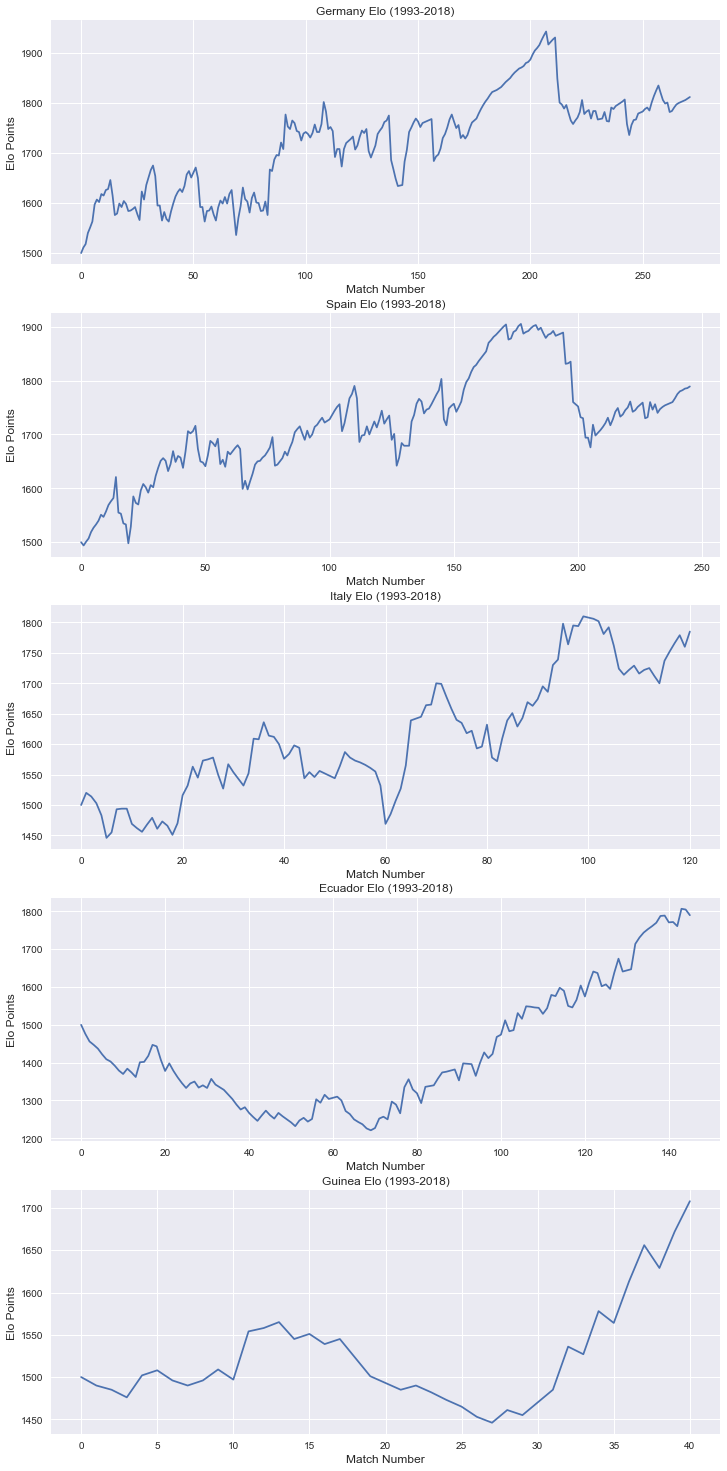

In [205]:
# capture top 5 teams and plot elo change with time for each team
elo_top5 = elo_teams_df.sort_values(['elo'], ascending=False).head(5)['team'].values.tolist()

fig, axs = plt.subplots(5,1, figsize=(12, 26), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, team in enumerate(elo_top5):
    team_df = elo_games_df[(elo_games_df['home_team'] == team) | (elo_games_df['away_team'] == team)] 
    
    elo_over_time = []
    for row in team_df.itertuples():
        if(row.home_team == team):
            elo_over_time.append(row.home_elo_before_game)
        else:
            elo_over_time.append(row.away_elo_before_game)

    axs[i].plot(elo_over_time)
    axs[i].set_ylabel('Elo Points', fontsize=12)
    axs[i].set_title('{} Elo (1993-2018)'.format(team))
    axs[i].set_xlabel('Match Number', fontsize=12) 

plt.show()

In [206]:
# reset index before merge
df_teams = df_teams.drop(['index'], axis = 1)
df_teams = df_teams.reset_index()

# join Elo scores with world cup team games dataset
train_results_df = df_teams.merge(elo_games_df, 
                        left_on='index', 
                        right_on='index')

train_results_df.head()

,index,date_x,home_team_x,away_team_x,home_score_x,away_score_x,tournament_x,city,country,neutral,...,home_team_y,away_team_y,home_score_y,away_score_y,tournament_y,result_y,home_elo_before_game,home_elo_after_game,away_elo_before_game,away_elo_after_game
0,0,1993-09-19,Brazil,Uruguay,2,0,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,...,Brazil,Uruguay,2,0,FIFA World Cup qualification,1.0,1500,1530,1500,1470
1,1,1995-10-11,Brazil,Uruguay,2,0,Friendly,Salvador,Brazil,False,...,Brazil,Uruguay,2,0,Friendly,1.0,1530,1542,1470,1457
2,2,1999-07-18,Brazil,Uruguay,3,0,Copa América,Asunción,Paraguay,True,...,Brazil,Uruguay,3,0,Copa América,1.0,1542,1568,1457,1430
3,3,2000-06-28,Brazil,Uruguay,1,1,FIFA World Cup qualification,Rio de Janeiro,Brazil,False,...,Brazil,Uruguay,1,1,FIFA World Cup qualification,0.5,1568,1560,1430,1437
4,4,2003-11-19,Brazil,Uruguay,3,3,FIFA World Cup qualification,Curitiba,Brazil,False,...,Brazil,Uruguay,3,3,FIFA World Cup qualification,0.5,1560,1553,1437,1443


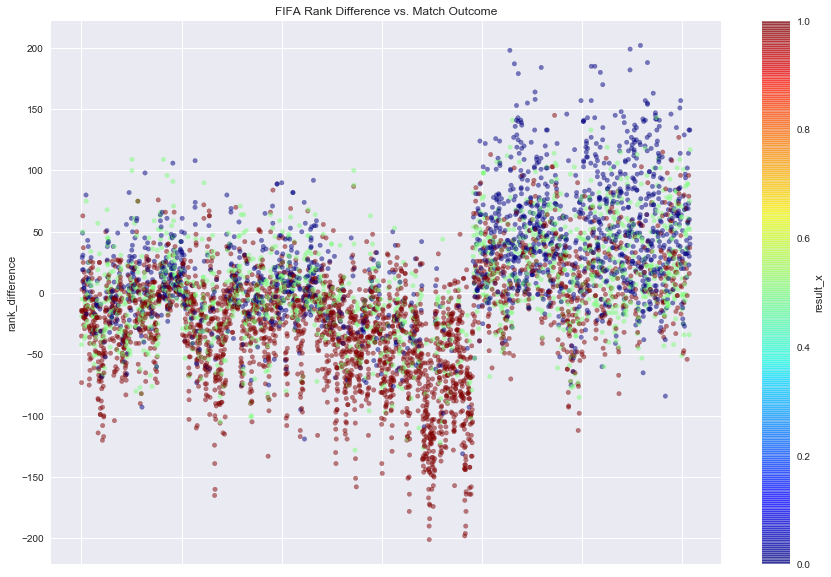

In [207]:
plt.rcParams['figure.figsize'] = (15,10)
train_results_df.plot.scatter('index','rank_difference', c='result_x', colormap='jet', alpha=0.5,
                             title = 'FIFA Rank Difference vs. Match Outcome')
plt.show()

In [208]:
train_results_df['fifa_upsets'] = ((train_results_df.home_score_x > train_results_df.away_score_x) & \
                              (train_results_df.rank_home < train_results_df.rank_away)) | \
                              ((train_results_df.away_score_x > train_results_df.home_score_x) & \
                               (train_results_df.rank_away < train_results_df.rank_home))
    
train_results_df['elo_upsets'] = ((train_results_df.home_score_x > train_results_df.away_score_x) & \
                              (train_results_df.home_elo_before_game < train_results_df.away_elo_before_game)) | \
                              ((train_results_df.away_score_x > train_results_df.home_score_x) & \
                               (train_results_df.away_elo_before_game < train_results_df.home_elo_before_game))
        
print('Number of Upsets based on FIFA Rank: {}%'
      .format(round(train_results_df.fifa_upsets.sum()/train_results_df.fifa_upsets.count()*100, 1)))

print('Number of Upsets based on Elo Score: {}%'
      .format(round(train_results_df.elo_upsets.sum()/train_results_df.elo_upsets.count()*100, 1)))

Number of Upsets based on FIFA Rank: 55.8%
Number of Upsets based on Elo Score: 20.0%


In [209]:
# remove features without predictive value or not known prior to game start
train_elo_df = train_results_df[['neutral','home_elo_before_game','away_elo_before_game','rank_home','previous_points_home',
                             'cur_year_avg_weighted_home','two_year_ago_weighted_home','three_year_ago_weighted_home',
                             'rank_away','previous_points_away','cur_year_avg_weighted_away','two_year_ago_weighted_away',
                             'three_year_ago_weighted_away','is_stake','rank_difference','average_rank',
                             'Region_Europe & Central Asia_home','Region_Latin America & Caribbean_home',
                             'Region_Middle East & North Africa_home','Region_North America_home','Region_South Asia_home',
                             'Region_Sub-Saharan Africa_home','IncomeGroup_High income: nonOECD_home',
                             'IncomeGroup_Low income_home','IncomeGroup_Lower middle income_home',
                             'IncomeGroup_Upper middle income_home','Region_Europe & Central Asia_away',
                             'Region_Latin America & Caribbean_away','Region_Middle East & North Africa_away',
                             'Region_North America_away','Region_South Asia_away','Region_Sub-Saharan Africa_away',
                             'IncomeGroup_High income: nonOECD_away','IncomeGroup_Low income_away',
                             'IncomeGroup_Lower middle income_away','IncomeGroup_Upper middle income_away','result_x']]

In [210]:
# split training set in features/labels
features = train_elo_df.drop(['result_x'], axis = 1)
labels = np.asarray(train_elo_df['result_x'], dtype="|S6")

features.head()

,neutral,home_elo_before_game,away_elo_before_game,rank_home,previous_points_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,rank_away,previous_points_away,...,Region_Europe & Central Asia_away,Region_Latin America & Caribbean_away,Region_Middle East & North Africa_away,Region_North America_away,Region_South Asia_away,Region_Sub-Saharan Africa_away,IncomeGroup_High income: nonOECD_away,IncomeGroup_Low income_away,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away
0,False,1500,1500,8.0,55.0,0.0,0.0,0.0,22.0,47.0,...,0,1,0,0,0,0,1,0,0,0
1,False,1530,1470,1.0,68.0,0.0,0.0,0.0,36.0,49.0,...,0,1,0,0,0,0,1,0,0,0
2,True,1542,1457,1.0,817.0,0.0,0.0,0.0,74.0,461.0,...,0,1,0,0,0,0,1,0,0,0
3,False,1568,1430,1.0,830.0,0.0,0.0,0.0,43.0,550.0,...,0,1,0,0,0,0,1,0,0,0
4,False,1560,1437,1.0,854.0,0.0,0.0,0.0,20.0,654.0,...,0,1,0,0,0,0,1,0,0,0


In [211]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, 
                                                                            random_state = 42)

In [212]:
baselineModel = DecisionTreeClassifier(max_depth=4).fit(train_features, train_labels)

print('Decision Tree Classifier:')
print('Classification Accuracy on training set: {}%'.format(round(baselineModel.score(train_features, train_labels,)*100, 2)))
print('Classification Accuracy on testing set: {}%\n'.format(round(baselineModel.score(test_features, test_labels,)*100, 2)))

Decision Tree Classifier:
Classification Accuracy on training set: 58.79%
Classification Accuracy on testing set: 56.78%



# Part 3: Ensemble Learners

The optimal combination of features from parts 1 and 2 (may include FIFA rank, Elo score, or both) will be used to train a variety of classification models (Random Forest, xgboost, LDA, QDA, KNN, etc.). The probabilistic results for each match (win, tie, loss) will be blended with the results of a Poisson Distribution model that uses the complete player ranking data scraped from sofifa.com for the FIFA 2018 video game to predict the group stages of the 2018 FIFA World Cup. The knockout stages of the world cup will be simulated 1000 times to determine the probability of each team winning the tournament. Matches that result in a tie during the knockout stages will take into account the average penalty rating of the top 5 penalty shooters for each time from the sofifa.com data set to break the tie. The final result will be the probability of each of the 32 teams that qualified for the 2018 World Cup to win the tournament.

## RandomForestClassifier

In [213]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 500 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [214]:
# Use the forest predict method on the test data
predictions = rf.predict(test_features)

# View the predicted probabilities of the first 10 observations
rf.predict_proba(test_features)[0:10]

array([[0.134, 0.192, 0.674],
       [0.236, 0.574, 0.19 ],
       [0.206, 0.208, 0.586],
       [0.062, 0.192, 0.746],
       [0.074, 0.624, 0.302],
       [0.352, 0.236, 0.412],
       [0.368, 0.328, 0.304],
       [0.092, 0.148, 0.76 ],
       [0.46 , 0.306, 0.234],
       [0.682, 0.076, 0.242]])

In [215]:
predictions[0:10]

array([b'1.0', b'0.5', b'1.0', b'1.0', b'0.5', b'1.0', b'0.0', b'1.0',
       b'0.0', b'0.0'], dtype='|S6')

In [216]:
# Create confusion matrix
pd.crosstab(test_labels, predictions, rownames=['Actual Outcome'], colnames=['Predicted Outcome']).apply(lambda r: r/r.sum(), axis=1)

Predicted Outcome,b'0.0',b'0.5',b'1.0'
Actual Outcome,,,
b'0.0',0.460000,0.137500,0.402500
b'0.5',0.304000,0.138667,0.557333
b'1.0',0.115436,0.069799,0.814765


In [217]:
from sklearn.metrics import accuracy_score

# Test Accuracy
print('Test Accuracy: {}'.format(accuracy_score(test_labels, predictions)))

Test Accuracy: 0.5546052631578947


In [218]:
# get feature names
feature_list = list(features.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: rank_difference                Importance: 0.13
Variable: home_elo_before_game           Importance: 0.1
Variable: away_elo_before_game           Importance: 0.1
Variable: previous_points_away           Importance: 0.09
Variable: rank_home                      Importance: 0.08
Variable: previous_points_home           Importance: 0.08
Variable: rank_away                      Importance: 0.08
Variable: average_rank                   Importance: 0.07
Variable: neutral                        Importance: 0.02
Variable: cur_year_avg_weighted_home     Importance: 0.02
Variable: two_year_ago_weighted_home     Importance: 0.02
Variable: three_year_ago_weighted_home   Importance: 0.02
Variable: cur_year_avg_weighted_away     Importance: 0.02
Variable: two_year_ago_weighted_away     Importance: 0.02
Variable: three_year_ago_weighted_away   Importance: 0.02
Variable: is_stake                       Importance: 0.02
Variable: Region_Europe & Central Asia_home Importance: 0.01
Variable: Reg

## LDA 
Working

In [219]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis().fit(train_features, train_labels)
#fitted_qda = QuadraticDiscriminantAnalysis().fit(x_train, y_train)

print("Model Test Set Score:", lda.score(test_features, test_labels))

# make a dumb prediction that always guesses 1, the most common class
#dumb_prediction = np.ones(len(y_test))
#print("Trivial Test Set Score:", np.sum(y_test == dumb_prediction)/len(y_test))

Model Test Set Score: 0.5703947368421053


C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## QDA 

Working

In [220]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis().fit(train_features, train_labels)

print("Model Test Set Score:", qda.score(test_features, test_labels))

Model Test Set Score: 0.26052631578947366


C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## KNN
Working

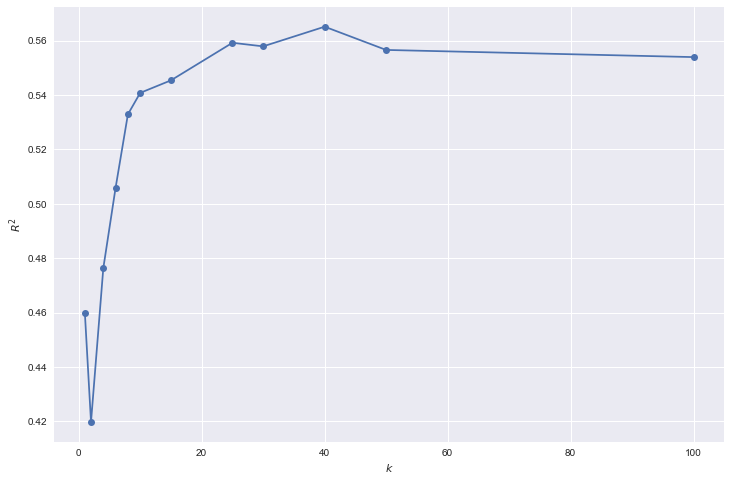

In [251]:
from sklearn.neighbors import KNeighborsClassifier
ks = [1, 2, 4, 6, 8, 10, 15, 25, 30, 40, 50, 100]
scores_train = [] # R2 scores
for k in ks:
    knnreg = KNeighborsClassifier(n_neighbors=k) # Create KNN model
    knnreg.fit(train_features, train_labels)
    score_train = knnreg.score(test_features, test_labels) # Calculate R^2 score
    scores_train.append(score_train)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(ks, scores_train,'o-')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$R^{2}$')

In [252]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=40)

knn.fit(train_features, train_labels)
knn.score(test_features, test_labels)

0.5651315789473684

## XGBoost

In [257]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=1).fit(train_features, train_labels)
#xgb.score(train_features, train_labels)
xgb.score(test_features, test_labels)

C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5736842105263158

## Combine the models

In [259]:
model_names = ['baselineModel', 'lda', 'knn', 'xgb']
models = [baselineModel, lda, knn, xgb]

# Build ensemble tune
pred_tune = []
pred_test = []

for i in np.arange(4):
    y_hat_tune = models[i].predict(train_features)
    print("type model {}".format(i), type(y_hat_tune))
    pred_tune.append(y_hat_tune)
    y_hat_test = models[i].predict(test_features)
    pred_test.append(y_hat_test)
ensemble_tune = np.transpose(np.array(pred_tune).astype(np.float))
ensemble_test = np.transpose(np.array(pred_test).astype(np.float))
#train_labels = np.array(train_labels).astype(np.float)
#test_labels = np.array(test_labels).astype(np.float)
#for i in np.arange(4):
print("Train accuracy ( {}): ".format(model_names[i]), np.mean(ensemble_tune[:,i] == train_labels))
print("Test accuracy ( {}): ".format(model_names[i]), np.mean(ensemble_test[:,i] == test_labels))

type model 0 <class 'numpy.ndarray'>
type model 1 <class 'numpy.ndarray'>
type model 2 <class 'numpy.ndarray'>
type model 3 <class 'numpy.ndarray'>
Train accuracy ( xgb):  0.0
Test accuracy ( xgb):  0.0


C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [260]:
from sklearn.metrics import accuracy_score

fitted_logreg = LogisticRegressionCV().fit(ensemble_tune, train_labels)
print("Number of coeffecients (One weight for each model) : {} ".format(fitted_logreg.coef_.shape[1]))
y_hat = fitted_logreg.predict(ensemble_test)
print("Test accuracy (Classify by LogReg on individual predictions): ", accuracy_score(test_labels, y_hat))\

Number of coeffecients (One weight for each model) : 4 
Test accuracy (Classify by LogReg on individual predictions):  0.569078947368421


In [261]:
ensemble_tune_df = pd.DataFrame(ensemble_tune, columns = model_names)
ensemble_test_df = pd.DataFrame(ensemble_test, columns = model_names)

ensemble_tune_df = ensemble_tune_df.join(train_features.reset_index())
ensemble_test_df = ensemble_test_df.join(test_features.reset_index())

clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(ensemble_tune_df, train_labels)
#clf.score(ensemble_test_df, test_labels)
print("Train accuracy (Agumented model): ", clf.score(ensemble_tune_df, train_labels))
print("Test accuracy (Agumented model): ", clf.score(ensemble_test_df, test_labels))

Train accuracy (Agumented model):  0.6076366030283081
Test accuracy (Agumented model):  0.5677631578947369


## ADA 
 
Note : Not able to multi-class ( note to self : research on multi-class for ADABoost ) 

ValueError: Can't handle mix of unknown and multiclass

In [51]:
# from sklearn.ensemble import AdaBoostClassifier

# ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), 
#                          n_estimators=400, learning_rate=0.5).fit(train_features, train_labels);
# ada.score(train_features, train_features)

# ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=400, learning_rate=0.5).fit(X_train, y_train)
# plt.figure(figsize=(15,6))
# plt.plot(np.arange(400), list(ada.staged_score(X_train,y_train)),label="Training score")
# plt.plot(np.arange(400), list(ada.staged_score(X_test,y_test)),label="Test score")
# plt.xlabel("Estimators")
# plt.ylabel("Score")
# plt.title("AdaBoostClassifier")
# plt.legend(loc="best")
# plt.show()

# fig, ax = plt.subplots(4, figsize=(15,20))
# for d in np.arange(4):
#     ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d+1), n_estimators=100, learning_rate=0.5).fit(X_train, y_train)
#     score = list(ada.staged_score(X_train,y_train))
#     ax[d].plot(np.arange(100), list(ada.staged_score(X_train,y_train)),label="Training score")
#     ax[d].plot(np.arange(100), list(ada.staged_score(X_test,y_test)),label="Testing score") 
#     ax[d].set(xlabel='Estimators', ylabel='Score', title='AdaBoostClassifier')

## Bruno Work

In [52]:
from scipy.stats import poisson,skellam
from league_team_names import epl_team_dict, bundesliga_team_dict, laliga_team_dict, seriea_teams_dict

#country_group_dict = pd.read_csv('worldcup_country_groups.csv', ).to_dict
players_df = pd.read_csv('CompleteFIFA2018PlayerDataset.csv')

epl2018 = pd.read_csv('epl2018.csv')
bundesliga2018 = pd.read_csv('bundesliga2018.csv')
seriea2018 = pd.read_csv('seriea2018.csv')
laliga2018 = pd.read_csv('laliga2018.csv')

C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (23,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
players_df.head()

,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,...,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,...,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0
3,3,L. Suárez,30,https://cdn.sofifa.org/48/18/players/176580.png,Uruguay,https://cdn.sofifa.org/flags/60.png,92,92,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,...,64.0,58.0,80.0,65.0,88.0,85.0,88.0,87.0,68.0,88.0
4,4,M. Neuer,31,https://cdn.sofifa.org/48/18/players/167495.png,Germany,https://cdn.sofifa.org/flags/21.png,92,92,FC Bayern Munich,https://cdn.sofifa.org/24/18/teams/21.png,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning the Data
We start with cleaning the dataset containing the detailed stats for each of the FIFA 18 video game's nearly 18,000 players. Each player has 75 columns of attributes. We drop most of the columns as we are concerned in only the player's overall rating and their position.

In [54]:
print(players_df.shape)
players_df[['Name', 'Overall', 'Preferred Positions']].head()

(17981, 75)


,Name,Overall,Preferred Positions
0,Cristiano Ronaldo,94,ST LW
1,L. Messi,93,RW
2,Neymar,92,LW
3,L. Suárez,92,ST
4,M. Neuer,92,GK


C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


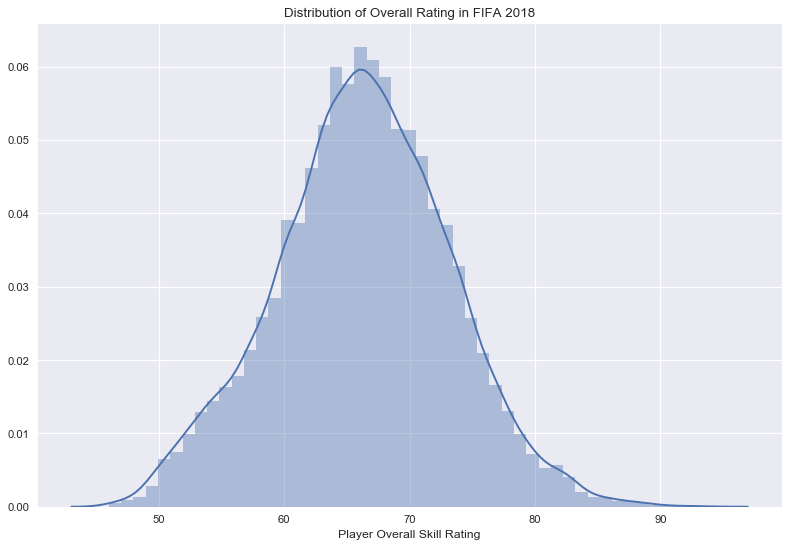

In [55]:
plt.figure(figsize=(12, 8), dpi= 80)
sns.distplot(players_df['Overall'], bins = 49)
sns.set(style='darkgrid')
plt.title('Distribution of Overall Rating in FIFA 2018')
plt.xlabel('Player Overall Skill Rating')
plt.show()

In [56]:
players_df['Overall'].std()

6.987965339747166

Another step in cleaning the data is to group the positions of the players into categories. The idea is to then aggregate the individual scores of each kind of position into three team attributes: 
- Attack
- Midfield
- Defense

Then we apply these categories to the player data.

In [57]:
positions_dict = {'ST': 'Attack',
                  'RW': 'Attack',
                  'LW': 'Attack',
                  'GK': 'Defense',
                  'CDM': 'Midfield',
                  'CB': 'Defense',
                  'RM': 'Midfield',
                  'CM': 'Midfield',
                  'LM': 'Midfield',
                  'LB': 'Defense',
                  'CAM': 'Attack',
                  'RB': 'Defense',
                  'CF': 'Attack',
                  'RWB': 'Defense',
                  'LWB': 'Defense'}

player_overall_df = players_df[['Name', 'Nationality', 'Preferred Positions', 'Overall']].copy()
player_overall_df['Preferred Positions'] = player_overall_df['Preferred Positions']\
                                        .apply(lambda x: x.split(' ', 1)[0]).replace(positions_dict)
player_overall_df.head()

,Name,Nationality,Preferred Positions,Overall
0,Cristiano Ronaldo,Portugal,Attack,94
1,L. Messi,Argentina,Attack,93
2,Neymar,Brazil,Attack,92
3,L. Suárez,Uruguay,Attack,92
4,M. Neuer,Germany,Defense,92


## Aggregating Team Stats
With the individual player data categorized into Attack, Midfield & Defense, we can write the following code that will calculate and output team level ratings. Let's try getting the ratings for a couple teams.

In [58]:
def get_team_stats(team, type='Nationality', no_of_players=20, return_df=False):
    mask = player_overall_df[type] == team
    groupby_cols = [type, 'Preferred Positions']
    team_stats_df = player_overall_df[mask].head(no_of_players).groupby(groupby_cols).mean().round(0)
    if return_df == True:
        return team_stats_df
    else:
        df = team_stats_df.reset_index().pivot(type, 'Preferred Positions')
        attack = df['Overall'].values[0][0]
        mid = df['Overall'].values[0][1]
        defense = df['Overall'].values[0][2]
        return [attack, mid, defense]

In [59]:
get_team_stats('United States', type='Nationality', return_df=True)

Overall
Nationality   Preferred Positions         
United States Attack                  76.0
              Defense                 76.0
              Midfield                77.0

## Building a dataset for training a model
In order to build a dataset for training models, we grab the schedules and results for each of the four main european leagues and merge them into a single dataset.

In [60]:
team_cols = ['HomeTeam', 'AwayTeam']
epl2018[team_cols] = epl2018[team_cols].replace(epl_team_dict)
bundesliga2018[team_cols] = bundesliga2018[team_cols].replace(bundesliga_team_dict)
seriea2018[team_cols] = seriea2018[team_cols].replace(seriea_teams_dict)
laliga2018[team_cols] = laliga2018[team_cols].replace(laliga_team_dict)

results_dict = {'H': 'HomeWin', "D": 'Draw', "A": 'AwayWin'}
cols = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']

league_results_df = pd.concat([epl2018, bundesliga2018, seriea2018, laliga2018])[cols]
league_results_df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR': 'Result'}, inplace=True)
league_results_df['Result'] = league_results_df['Result'].replace(results_dict)
league_results_df['Goal diff'] = league_results_df['HomeGoals'] - league_results_df['AwayGoals']

league_results_df.reset_index(drop=True, inplace=True)
league_results_df

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,Result,Goal diff
0,Arsenal,Leicester City,4,3,HomeWin,1
1,Brighton & Hove Albion,Manchester City,0,2,AwayWin,-2
2,Chelsea,Burnley,2,3,AwayWin,-1
3,Crystal Palace,Huddersfield Town,0,3,AwayWin,-3
4,Everton,Stoke City,1,0,HomeWin,1
5,Southampton,Swansea City,0,0,Draw,0
6,Watford,Liverpool,3,3,Draw,0
7,West Bromwich Albion,Bournemouth,1,0,HomeWin,1
8,Manchester United,West Ham United,4,0,HomeWin,4
9,Newcastle United,Tottenham Hotspur,0,2,AwayWin,-2


## Finalizing Training Dataset Format
To finalize our training dataset we can use the following code to replace the team names with their respective aggregate ratings based on the team's individual players.

In [61]:
homeTeam_attack = []
homeTeam_mid = []
homeTeam_def = []
awayTeam_attack = []
awayTeam_mid = []
awayTeam_def = []
data = []


for index, row in league_results_df.iterrows():
    try:
        home_team_stats = get_team_stats(row['HomeTeam'])
        home_attack = home_team_stats[0]
        home_midfield = home_team_stats[1]
        home_defense = home_team_stats[2]

        away_team_stats = get_team_stats(row['AwayTeam'])
        away_attack = away_team_stats[0]
        away_midfield = away_team_stats[1]
        away_defense = away_team_stats[2]
                
        homeTeam_attack.append(home_attack)
        homeTeam_mid.append(home_midfield)
        homeTeam_def.append(home_defense)
        awayTeam_attack.append(away_attack)
        awayTeam_mid.append(away_midfield)
        awayTeam_def.append(away_defense)

        
    except IndexError:
        homeTeam_attack.append(None)
        homeTeam_mid.append(None)
        homeTeam_def.append(None)
        awayTeam_attack.append(None)
        awayTeam_mid.append(None)
        awayTeam_def.append(None)
        continue
        
data = [homeTeam_attack, 
        homeTeam_mid, 
        homeTeam_def, 
        awayTeam_attack,
        awayTeam_mid, 
        awayTeam_def]

feature_cols = ['homeTeam_attack', 
                'homeTeam_mid', 
                'homeTeam_def', 
                'awayTeam_attack', 
                'awayTeam_mid',
                'awayTeam_def']

home_cols = ['homeTeam_attack', 
                'homeTeam_mid', 
                'homeTeam_def', 
                'awayTeam_attack', 
                'awayTeam_mid',
                'awayTeam_def']

away_cols = ['awayTeam_attack', 
             'awayTeam_mid',
             'awayTeam_def',
             'homeTeam_attack', 
             'homeTeam_mid', 
             'homeTeam_def']

rename_cols = ['A_Team_attack', 
               'A_Team_mid',
               'A_Team_def',
               'B_Team_attack', 
               'B_Team_mid', 
               'B_Team_def']
             

team_ratings_df = pd.DataFrame(data, index=feature_cols)

team_ratings_df = team_ratings_df.transpose()

team_ratings_df['HomeGoals'] = league_results_df['HomeGoals']
team_ratings_df['AwayGoals'] = league_results_df['AwayGoals']
team_ratings_df['result'] = league_results_df['Result']

team_ratings_df.dropna(inplace=True)

team_ratings_df.head()

,homeTeam_attack,homeTeam_mid,homeTeam_def,awayTeam_attack,awayTeam_mid,awayTeam_def,HomeGoals,AwayGoals,result


In [62]:
team_ratings_df.shape

(0, 9)

## Introducing Poisson Distribution
Poisson distributions represent the probability of a given number of events occurring in a fixed time if these events occur independently of the time since the last event. This somewhat matches the inherent randomness of the time that goals are scored in a soccer match. Lets see if we can use our training dataset again to train a Poisson distribution model that uses the team stats as inputs.

Here we have to use the goal count as the y value since Poisson calculates the probabilities of goals scored, instead of overall winner/loser. After we get a way to generate the probabilites of goals, we can later predict match outcomes.

In [63]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

home_team_df = team_ratings_df[home_cols].copy()
home_team_df.columns = rename_cols
away_team_df = team_ratings_df[away_cols].copy()
away_team_df.columns = rename_cols

X = pd.concat([home_team_df, away_team_df]).reset_index(drop=True)

y = pd.DataFrame(pd.concat([team_ratings_df['HomeGoals'], team_ratings_df['AwayGoals']]).reset_index(drop=True), columns=['goals'])

goal_model_data = X.join(y)

goal_model_data.head()

C:\Users\hanschacko\.conda\envs\hanspy\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,A_Team_attack,A_Team_mid,A_Team_def,B_Team_attack,B_Team_mid,B_Team_def,goals


In [64]:
poisson_model = smf.glm(formula="goals ~ A_Team_attack + A_Team_mid + A_Team_def + B_Team_attack + B_Team_mid + B_Team_def", 
                        data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

poisson_model.summary()

ValueError: negative dimensions are not allowed

In [ ]:
def simulate_goals(game, a_team='A Team', b_team='B Team', verbose=False):
    a_goals = 0
    b_goals = 0
    outcome = 0

    random_event = np.random.random()
    counter = 0


    for index, row in pd.DataFrame(data=game).iterrows():
        for x in range(len(row)):
            counter += row[x]
            
            a_goals = index
            b_goals = x
            
            if counter > random_event:
                break
        if counter > random_event:
            break
    
    if verbose == True:
        print('Random float: {}'.format(random_event))
        print('{} goals: {}'.format(a_team, str(a_goals)))
        print('{} goals: {}\n'.format(b_team, str(b_goals)))
    
    return a_goals, b_goals


def show_game_summary(game, a_team='A Team', b_team='B Team', verbose=False):
    a_team_odds = np.sum(np.tril(game, -1))
    b_team_odds = np.sum(np.triu(game, 1))
    draw_odds = np.sum(np.diag(game))
    
    if verbose == True:
        print('{} chance of Win: {}%'.format(a_team, round(a_team_odds*100, 2)))
        print('{} chance of Win: {}%'.format(b_team, round(b_team_odds*100, 2)))
        print('Odds of a draw: {}%'.format(round(draw_odds*100, 2)))
    
    a_goals, b_goals = simulate_goals(game, a_team, b_team, verbose=verbose)
    
    return a_team_odds, b_team_odds, draw_odds, a_goals, b_goals


def simulate_match(foot_model, a_team, b_team, type='Club', max_goals=9, verbose=False):
    a_team_stats = get_team_stats(a_team, type=type)
    b_team_stats = get_team_stats(b_team, type=type)
    
    data1 = {'A_Team_attack': a_team_stats[0],
              'A_Team_mid': a_team_stats[1],
              'A_Team_def': a_team_stats[2],
              'B_Team_attack': b_team_stats[0], 
              'B_Team_mid': b_team_stats[1], 
              'B_Team_def': b_team_stats[2]}
    
    data2 = {'A_Team_attack': b_team_stats[0],
              'A_Team_mid': b_team_stats[1],
              'A_Team_def': b_team_stats[2],
              'B_Team_attack': a_team_stats[0], 
              'B_Team_mid': a_team_stats[1], 
              'B_Team_def': a_team_stats[2]}
        
    a_goals_avg = foot_model.predict(pd.DataFrame(data=data1, index=[1])).values[0]
    b_goals_avg = foot_model.predict(pd.DataFrame(data=data2, index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [a_goals_avg, b_goals_avg]]
    game = (np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
    show_game_summary(game, a_team, b_team, verbose=verbose)
    return game

In [ ]:
data = pd.concat([get_team_stats('Spain', type='Nationality', return_df=True).reset_index(), get_team_stats('Portugal', type='Nationality', return_df=True).reset_index()])

sns.barplot(x='Preferred Positions', y='Overall', hue='Nationality', data=data)
plt.title(' Spain vs Portugal')
plt.xlabel('Team Stats')
plt.ylabel('Stat Rating')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig('spain_vs_portugal.png', bbox_inches='tight')
plt.show()

In [ ]:
game = simulate_match(poisson_model, 'Spain', 'Portugal', type='Nationality')
show_game_summary(game, 'Spain', 'Portugal', verbose=True)

In [ ]:
pd.DataFrame(game)

In [105]:
wc2018_df = pd.read_csv('2018WorldCupSchedule-withResults.csv')
wc2018_df['Date'] = pd.to_datetime(wc2018_df['Date'])
wc2018_df.head()

FileNotFoundError: File b'2018WorldCupSchedule-withResults.csv' does not exist

In [ ]:
bookmaker2018_df = pd.read_csv('BookmakerOdds.csv')
bookmaker2018_df.head()

In [ ]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()